In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.size'] = 14

In [2]:
# Path to figures
path_to_figs = Path.cwd().parent.parent.parent / 'results' / 'xojn'
path_to_figs.mkdir(exist_ok=True)

In [3]:
# Global variables
JOBS = {'BASE OLD':'xojnd',
        'BASE'    :'xojng',
        'CHEM'    :'xojnh',
        'MARI'    :'xojni',
        'FIRE'    :'xojnc',
        'FULL'    :'xojnl',
        'ORIG'    :'xolnb',
        'UPDT'    :'xolna'}
VARIABLES = {'molar_mass': {'o3':47.997, 'no':30.006, 'no2':46.006, 'hono':47.013, 'ho2no2':79.01224, 'hno3':63.012, 'n2o5':108.01, 
                            'pan':121.0489, 'ppan':135.0755,
                            'meono2':77.0394, 'etono2':91.0660, 'nprono2':105.0926, 'iprono2':105.0926,
                            'ch4':16.0425, 'c2h6':30.0690},
             'latex': {'o3':'$O_3$', 'no':'NO', 'no2':'$NO_2$', 'hono':'HONO', 'ho2no2':'$HO_2NO_2$', 'hno3':'$HNO_3$', 'n2o5':'N_2O_5', 
                       'pan':'PAN', 'ppan':'PPN', 
                       'nox':'$NO_x$', 'noy':'$NO_y$', 'meono2':'$MeONO_2$', 'etono2':'$EtONO_2$', 'nprono2':'$nPrONO_2$', 'iprono2':'$iPrONO_2$',
                       'ch4':'$CH_4$', 'c2h6':'$C_2H_6$'}}
M_air = 28.97 # molar mass of dry air [g mol-1]

In [4]:
# Switches
exp = 'FULL'
var = 'rono2'
savefig = False

In [5]:
# Read data
job = JOBS[exp]
path_to_ukca = Path.cwd().parent / 'raw'
if var == 'rono2':
    cb1 = iris.load_cube(str(path_to_ukca / job / f'{job}_meono2.nc'), 'meono2')*(M_air/(VARIABLES['molar_mass']['meono2']))*1e12
    cb2 = iris.load_cube(str(path_to_ukca / job / f'{job}_etono2.nc'), 'etono2')*(M_air/(VARIABLES['molar_mass']['etono2']))*1e12
    cb3 = iris.load_cube(str(path_to_ukca / job / f'{job}_nprono2.nc'), 'nprono2')*(M_air/(VARIABLES['molar_mass']['nprono2']))*1e12
    cb4 = iris.load_cube(str(path_to_ukca / job / f'{job}_iprono2.nc'), 'iprono2')*(M_air/(VARIABLES['molar_mass']['iprono2']))*1e12
    cb = cb1.copy() + cb2.copy() + cb3.copy() + cb4.copy()
else:
    cb = iris.load_cube(str(path_to_ukca / job / f'{job}_{var}.nc'), var)*(M_air/VARIABLES['molar_mass'][var])*1e12
cb = cb[24::,...] # remove the first 2 years as a spin up
# Add season and year coordinates
iris.coord_categorisation.add_season(cb, 'time', name='season')
iris.coord_categorisation.add_season_year(cb, 'time', name='year')
# Simplify dimensions
lons = cb.coord('longitude').points
lats = cb.coord('latitude').points

#### Zonal seasonal means within 130-180W

In [6]:
# Define constraints
pacific = iris.Constraint(longitude=lambda cell: 180 < cell < 230)
below_12_km = iris.Constraint(level_height=lambda cell: 0 < cell.point < 12000) # mid 11520.002, bounds = [11049.996, 12009.998]
winter = iris.Constraint(season='djf')
spring = iris.Constraint(season='mam')
summer = iris.Constraint(season='jja')
autumn = iris.Constraint(season='son')
# Extract data
pac_znl_djf = cb.extract(pacific & below_12_km & winter)
pac_znl_mam = cb.extract(pacific & below_12_km & spring)
pac_znl_jja = cb.extract(pacific & below_12_km & summer)
pac_znl_son = cb.extract(pacific & below_12_km & autumn)
# Average data
pac_znl_djf_ave = pac_znl_djf.collapsed(['longitude', 'season'], iris.analysis.MEAN)
pac_znl_mam_ave = pac_znl_mam.collapsed(['longitude', 'season'], iris.analysis.MEAN)
pac_znl_jja_ave = pac_znl_jja.collapsed(['longitude', 'season'], iris.analysis.MEAN)
pac_znl_son_ave = pac_znl_son.collapsed(['longitude', 'season'], iris.analysis.MEAN)

In [7]:
# Merge two colormaps: color values present in GEOS-Chem and UM-UKCA using one colormap and UM-UKCA higher than GEOS-Chem using another colormap
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
colors_low = plt.cm.viridis(np.linspace(0,1,128))
colors_high = plt.cm.autumn_r(np.linspace(0,1,128))
colors_stack = np.vstack((colors_low, colors_high))
mrgd_cmap = colors.LinearSegmentedColormap.from_list('merged_cmap', colors_stack)

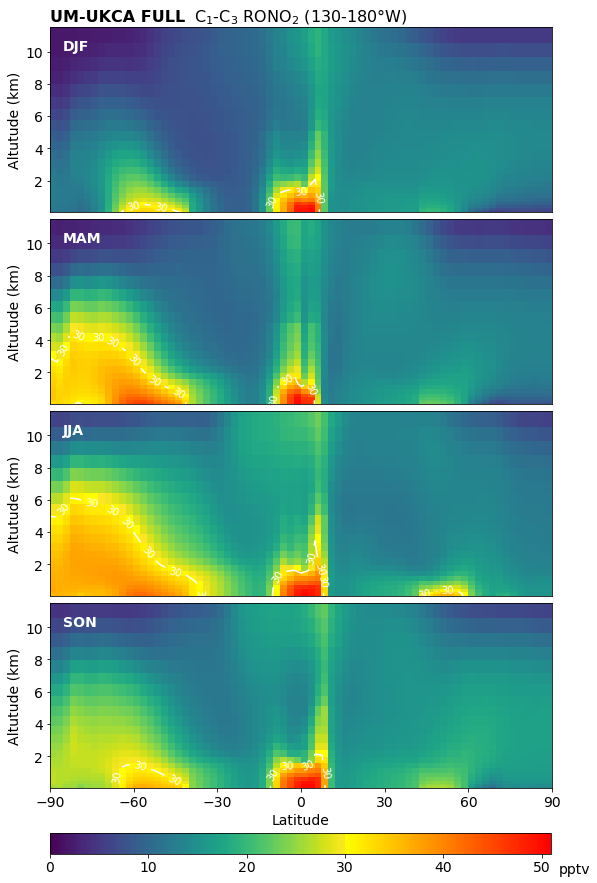

In [12]:
# Plot zonal seasonal means within 130-180W 
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9,14), facecolor='w', sharex=True)
levs = pac_znl_djf.coord('level_height').points/1000
p0 = ax[0].pcolormesh(lats, levs, pac_znl_djf_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)
p1 = ax[1].pcolormesh(lats, levs, pac_znl_mam_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)
p2 = ax[2].pcolormesh(lats, levs, pac_znl_jja_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)
p3 = ax[3].pcolormesh(lats, levs, pac_znl_son_ave.data, norm=MidpointNormalize(midpoint=30), cmap=mrgd_cmap, vmin=0)

cax = fig.add_axes([0.125, 0.06, 0.773, 0.02]) # [left, bottom, width, height]
cbar = fig.colorbar(p3, cax=cax, orientation='horizontal') #, extend='max')
fig.text(0.91, 0.041, 'pptv', fontsize=14)
# cmap = plt.cm.get_cmap('viridis')
# cmap.set_over('gold')

c0 = ax[0].contour(lats, levs, pac_znl_djf_ave.data, levels=[30], colors='w')
c1 = ax[1].contour(lats, levs, pac_znl_mam_ave.data, levels=[30], colors='w')
c2 = ax[2].contour(lats, levs, pac_znl_jja_ave.data, levels=[30], colors='w')
c3 = ax[3].contour(lats, levs, pac_znl_son_ave.data, levels=[30], colors='w')

ax[0].add_artist(AnchoredText('DJF', loc=2, frameon=False, prop=dict(color='w', fontweight='bold', fontsize=14)))
ax[1].add_artist(AnchoredText('MAM', loc=2, frameon=False, prop=dict(color='w', fontweight='bold', fontsize=14)))
ax[2].add_artist(AnchoredText('JJA', loc=2, frameon=False, prop=dict(color='w', fontweight='bold', fontsize=14)))
ax[3].add_artist(AnchoredText('SON', loc=2, frameon=False, prop=dict(color='w', fontweight='bold', fontsize=14)))

ax[0].set_title(u'$C_1$-$C_3$ $RONO_2$ (130-180\u00b0W)', loc='center')
ax[0].set_title(f'UM-UKCA {exp}', loc='left', weight='bold')
ax[3].set_xlabel('Latitude')
ax[3].set_xticks([-90, -60, -30, 0, 30, 60, 90])
for iax in ax[0:3].flatten(): iax.xaxis.set_ticks_position('none')
for iax in ax.flatten():
    iax.set_ylabel('Altutude (km)')
    for c in [c0, c1, c2, c3]: 
        iax.clabel(c, fmt='%2i', colors='w')
fig.subplots_adjust(hspace=0.035)
if savefig: fig.savefig(path_to_figs / 'Fisher2018-like' / f'Fisher2018-like_{exp.lower()}_{var}.png', bbox_inches='tight')

In [9]:
break

SyntaxError: 'break' outside loop (<ipython-input-9-6aaf1f276005>, line 4)

#### Annual means to compare to Fisher et al (2018): 0-2, 2-6, 6-10 km

In [ ]:
ann_ave_0_2 = cb.aggregated_by(['year'], iris.analysis.MEAN)[:,0:10,...].collapsed(['year', 'level_height'], iris.analysis.MEAN)
ann_ave_2_6 = cb.aggregated_by(['year'], iris.analysis.MEAN)[:,10:17,...].collapsed(['year', 'level_height'], iris.analysis.MEAN)
ann_ave_6_1 = cb.aggregated_by(['year'], iris.analysis.MEAN)[:,17:22,...].collapsed(['year', 'level_height'], iris.analysis.MEAN)
c_ann_ave_0_2, c_lons = cartopy.util.add_cyclic_point(ann_ave_0_2.data, coord=cb.coord('longitude').points)
c_ann_ave_2_6 = cartopy.util.add_cyclic_point(ann_ave_2_6.data)
c_ann_ave_6_1 = cartopy.util.add_cyclic_point(ann_ave_6_1.data)

In [ ]:
if var == 'meono2':
    cscale = 'sat' # 'saturated' or 'unsaturated'
    if cscale == 'sat':
        vmax0, vmax1, vmax2 = 10, 15, 20
    else:
        vmax0, vmax1, vmax2 = 40, 60, 80
if var in ['etono2', 'nprono2', 'iprono2']:
    cscale = 'sat'
    vmax0, vmax1, vmax2 = 10, 15, 20

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=230)), facecolor='w')
p0 = ax[0].pcolormesh(c_lons, lats, c_ann_ave_6_1.data, vmin=0, vmax=vmax0, transform=ccrs.PlateCarree())
p1 = ax[1].pcolormesh(c_lons, lats, c_ann_ave_2_6.data, vmin=0, vmax=vmax1, transform=ccrs.PlateCarree())
p2 = ax[2].pcolormesh(c_lons, lats, c_ann_ave_0_2.data, vmin=0, vmax=vmax2, transform=ccrs.PlateCarree())
ax[0].set_title(exp, loc='left', weight='bold')
ax[0].set_title(var_dict['latex'][var], loc='center')
cb0 = fig.colorbar(p0, ax=ax[0])
cb1 = fig.colorbar(p1, ax=ax[1])
cb2 = fig.colorbar(p2, ax=ax[2])
fig.text(0.84, 0.873, 'pptv')
fig.text(0.164, 0.87, '6-10 km')
fig.text(0.164, 0.61, '2-6 km')
fig.text(0.164, 0.35, '0-2 km')
fig.subplots_adjust(hspace=0.1)
for iax in ax.flatten(): iax.coastlines();
if savefig: fig.savefig(path_to_figs / 'Fisher2018-like' / f'Fisher2018-like_{exp.lower()}_{var}_{cscale}.png', bbox_inches='tight')#, dpi=200)